In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt

from math import ceil
from pathlib import Path
from seaborn import heatmap
from skimage.transform import rescale
from sklearn.metrics import confusion_matrix

from tensorflow.random import set_seed
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

set_seed(12)

Wall time: 3.12 s


In [2]:
def resample(image, shape):
    def seperate_pad_width(width):
        return (width // 2, ceil(width / 2))
    
    ratio = min(shape[0] / image.shape[0], shape[1] / image.shape[1])
    image = rescale(image, ratio, order = 1, preserve_range = True, multichannel = True)
    
    padding_axis = [seperate_pad_width(abs(image.shape[0] - shape[0])),
                    seperate_pad_width(abs(image.shape[1] - shape[1]))]
    image = np.pad(image, (padding_axis[0], padding_axis[1], (0,0)), constant_values = 0)
    
    return image

In [3]:
def read_file(path, output_shape = (32,32,1)):
    X, Y = [], []
    file = open(path, 'r')
    file.readline() # ignore  header
    
    for line in file.readlines():
        temp = line[ :-1].split('#')
        
        image_height = int(temp[3])
        image_width = int(temp[4])
        
        image = [(ord(i) & 1) * 255 for i in temp[-1]]
        image = np.array(image, dtype = 'uint8')
        image.resize(image_height, image_width, 1)
        image = resample(image, output_shape)
        
        label = int(temp[0])
        
        X.append(image)
        Y.append(label)
        
    image_count = len(Y)
    X = np.array(X, dtype = 'uint8')
    Y = to_categorical(Y, num_classes = 28, dtype = 'uint8')
    return X,Y

In [4]:
image_number = 0
label_map = 'ABCÇDEƏFGHIJKLMNOPQRSŞTUVXYZ'

def display_image(image, label):
    global image_number
    global label_map
    image_number += 1
    
    label = label_map [ label.argmax() ]
    plt.figure(image_number)
    plt.title('Label: {0}'.format(label))
    plt.imshow(image.squeeze(), cmap = plt.cm.gray_r)

In [5]:
%%time


train_path = Path('HandChars_150_Train.txt').absolute()
test_path = Path('HandChars_50_Test.txt').absolute()

shape = (32,28,1)
X_train, Y_train = read_file(train_path, shape)
X_test,  Y_test  = read_file(test_path, shape)

Wall time: 7.39 s


In [6]:
X_train.shape

(4200, 32, 28, 1)

In [7]:
X_test.shape

(1400, 32, 28, 1)

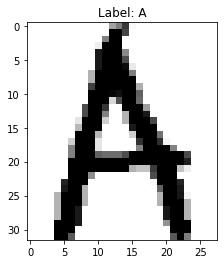

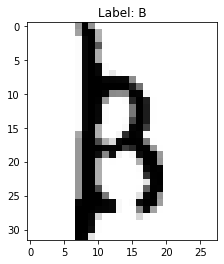

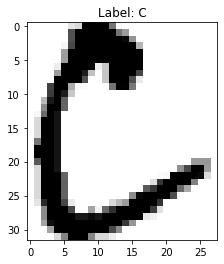

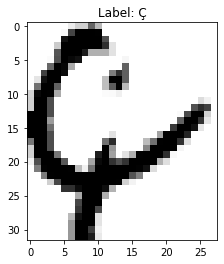

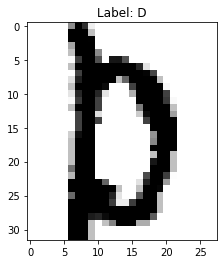

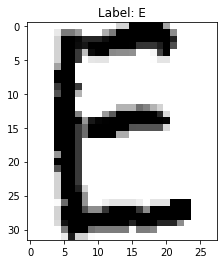

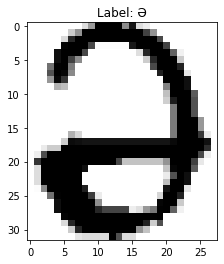

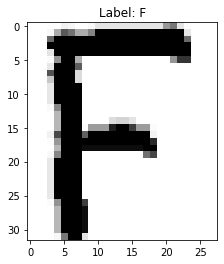

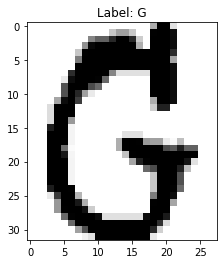

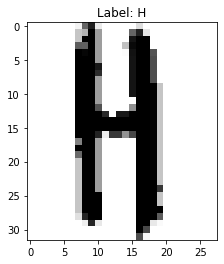

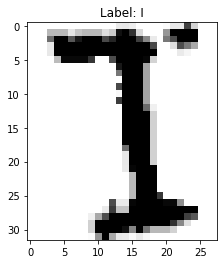

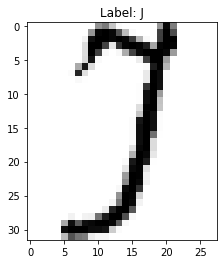

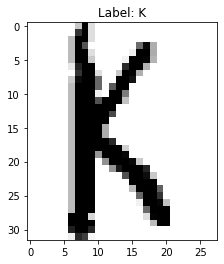

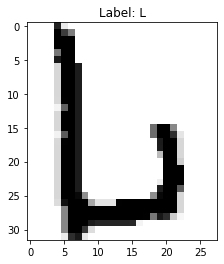

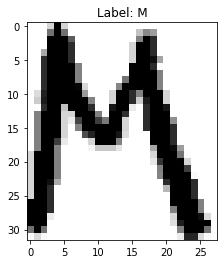

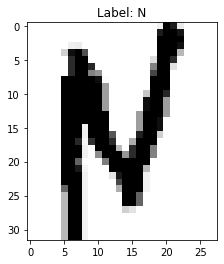

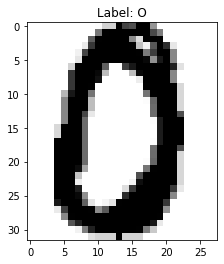

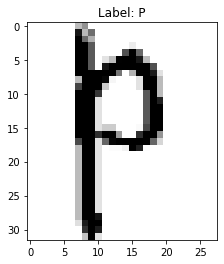

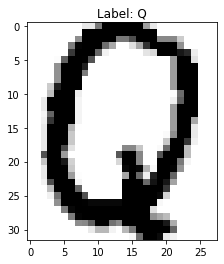

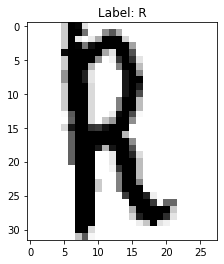

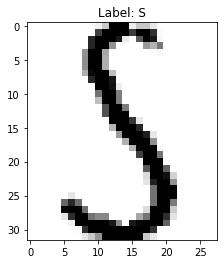

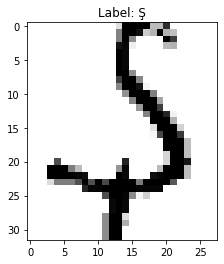

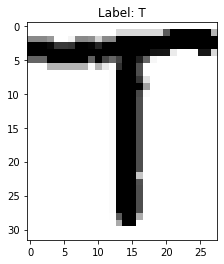

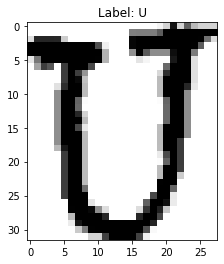

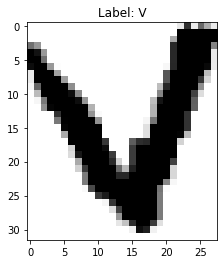

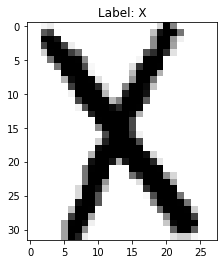

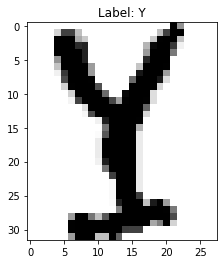

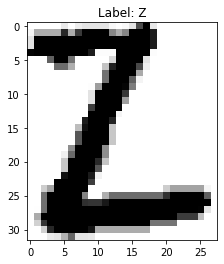

In [8]:
n_labels = 28
n_images = X_train.shape[0]
n_images_per_label = n_images // n_labels

for i in range(0, n_images, n_images_per_label):
    display_image(X_train[i], Y_train[i])

In [10]:
model = Sequential()

model.add(layers.Conv2D(filters = 8,  kernel_size = (5,5), padding = 'same', activation ='relu', input_shape = shape))
model.add(layers.Dropout(0.10, seed = 12))
model.add(layers.MaxPooling2D(pool_size = (2,2)))


model.add(layers.Conv2D(filters = 16, kernel_size = (5,5), padding = 'same', activation ='relu'))
model.add(layers.Dropout(0.15, seed = 12))
model.add(layers.MaxPooling2D(pool_size = (2,2)))


# fully connected
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dropout(0.32, seed = 12))

model.add(layers.Dense(28, activation = "softmax"))

model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics = ["accuracy"])

In [11]:
EPOCHS = 12
BATCH_SIZE = 30
model.fit(X_train, Y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, shuffle = True)

Epoch 1/12
140/140 [==============================] - 2s 15ms/step - loss: 7.0868 - accuracy: 0.3236
Epoch 2/12
140/140 [==============================] - 2s 15ms/step - loss: 0.9474 - accuracy: 0.7310
Epoch 3/12
140/140 [==============================] - 2s 15ms/step - loss: 0.4700 - accuracy: 0.8602
Epoch 4/12
140/140 [==============================] - 2s 16ms/step - loss: 0.3248 - accuracy: 0.8986
Epoch 5/12
140/140 [==============================] - 2s 16ms/step - loss: 0.2352 - accuracy: 0.9250
Epoch 6/12
140/140 [==============================] - 2s 16ms/step - loss: 0.2006 - accuracy: 0.9398
Epoch 7/12
140/140 [==============================] - 2s 16ms/step - loss: 0.1645 - accuracy: 0.9519
Epoch 8/12
140/140 [==============================] - 2s 16ms/step - loss: 0.1245 - accuracy: 0.9605
Epoch 9/12
140/140 [==============================] - 2s 17ms/step - loss: 0.1187 - accuracy: 0.9619
Epoch 10/12
140/140 [==============================] - 2s 16ms/step - loss: 0.1015 - accura

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 28, 8)         208       
_________________________________________________________________
dropout (Dropout)            (None, 32, 28, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 14, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 14, 16)        3216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 14, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 896)              

In [13]:
train_score = model.evaluate(X_train, Y_train)
test_score  = model.evaluate(X_test, Y_test)

44/44 [==============================] - 0s 6ms/step - loss: 0.7423 - accuracy: 0.8614


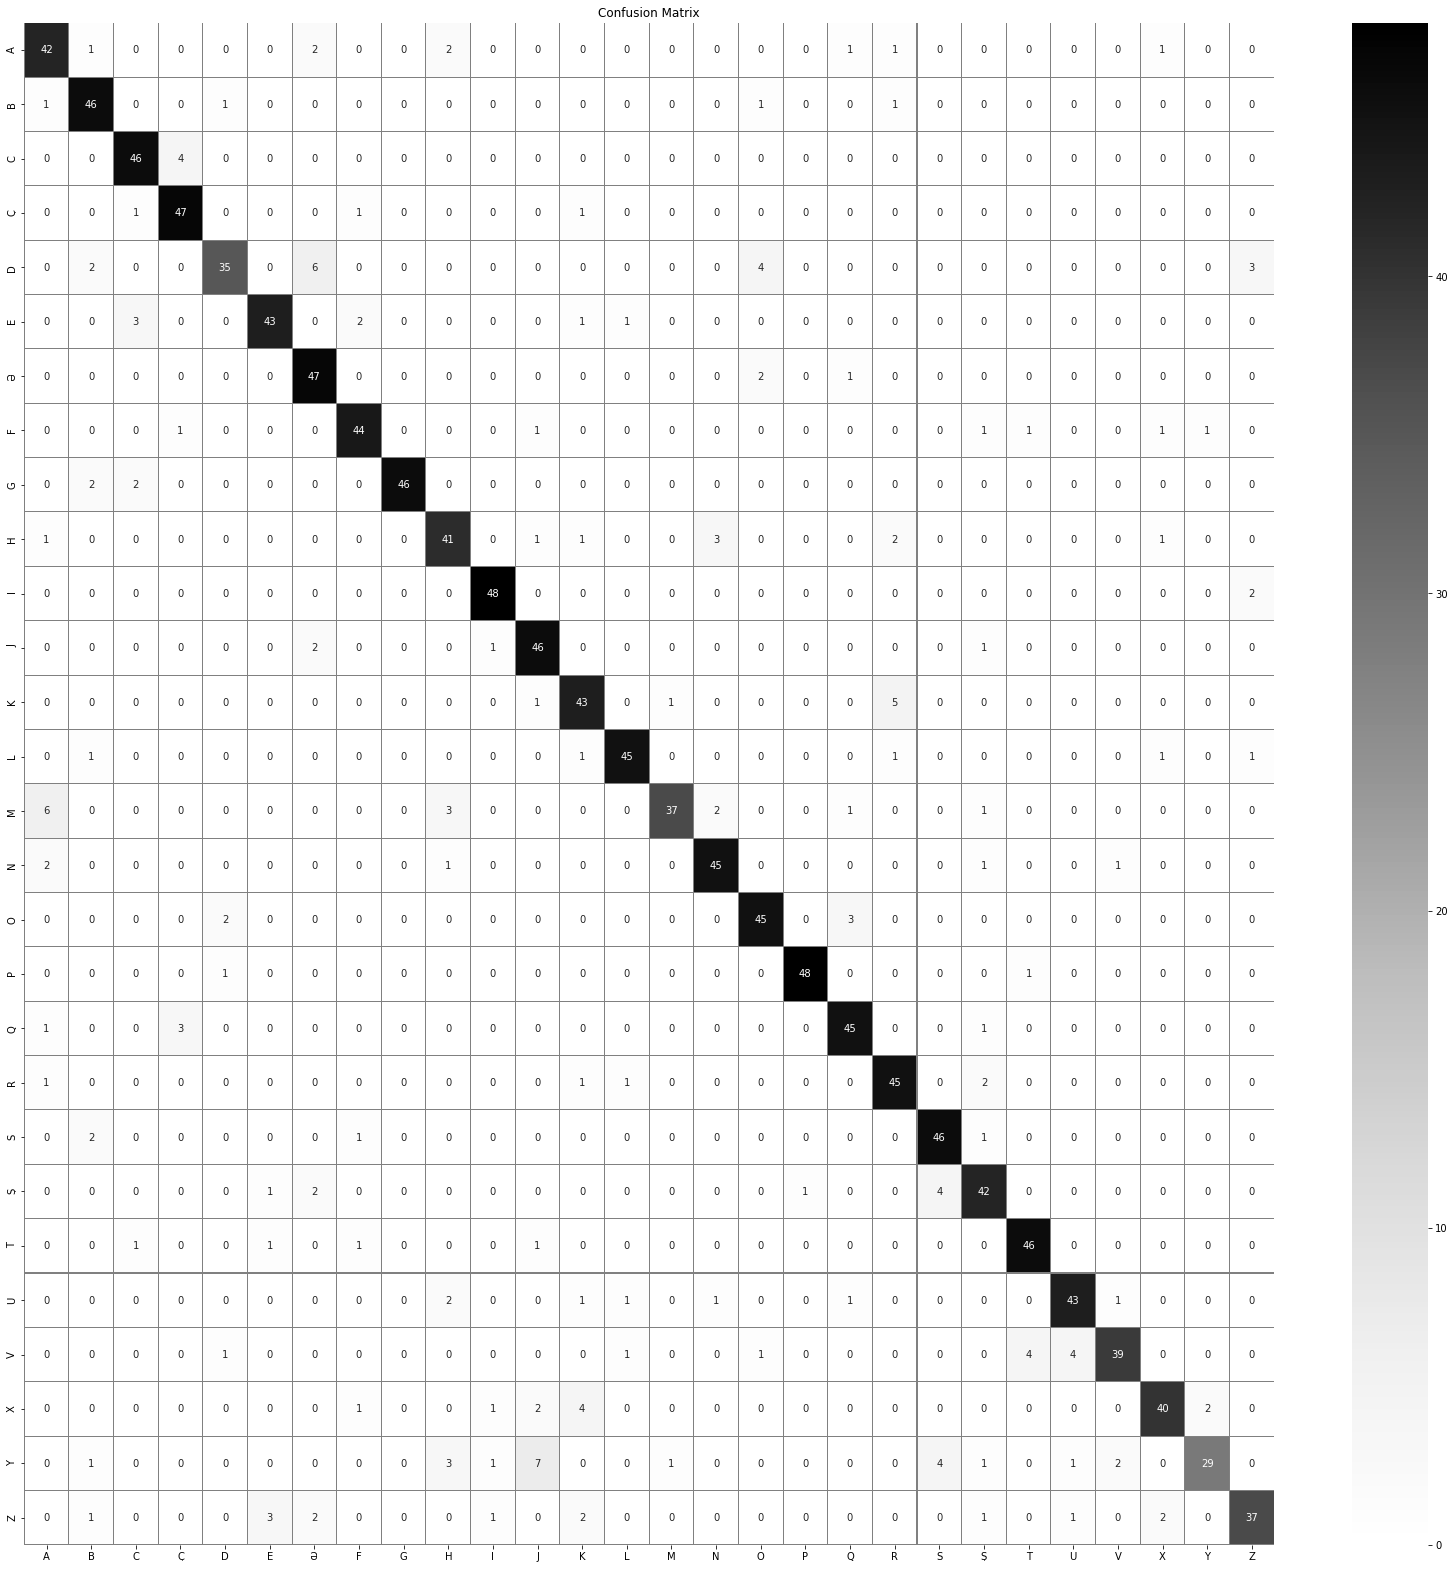

In [14]:
Y_pred = model.predict(X_test) 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
Y_classes = np.argmax(Y_test, axis = 1) 


confusion_mtx = confusion_matrix(Y_classes, Y_pred_classes) 

plt.subplots(figsize = (28, 28))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

heatmap(confusion_mtx, annot = True, linewidths = 0.02, cmap = "Greys", linecolor = "gray", xticklabels = label_map, yticklabels = label_map)
plt.show()